In [9]:
import pandas as pd
import sys
import pyspark.sql
from pyspark.sql.types import StructType, StructField, DateType, StringType, DoubleType, TimestampType
from SparkDBUtils import SparkDB
import datetime
from pyspark.sql.functions import current_timestamp
import delta

sparkdb = SparkDB()
spark = sparkdb.spark

In [18]:
producto_dim_schema = StructType([
        StructField("date", DateType(), True),
        StructField("product", StringType(), True),
        StructField("product_id", StringType(), True),
        StructField("brand", StringType(), True),
        StructField("price", DoubleType(), True),
        StructField("categories", StringType(), True),
        StructField("unit_price", DoubleType(), True),
        StructField("units", StringType(), True),
        StructField("discount", DoubleType(), True),
        StructField("ts_load", TimestampType(), True)
    ])

dataset = spark.read.option("delimiter", ";").csv("../../dataset/dataset.csv",  schema= producto_dim_schema, header=True)

In [19]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=None)

In [27]:
dataset = dataset.withColumn("ts_load", current_timestamp())

In [29]:
dataset.summary().show()

+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|summary|             product|        product_id|         brand|             price|          categories|        unit_price|          units|discount|
+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|  count|              258598|            258598|        251175|            258171|              258598|            258171|         258171|       0|
|   mean|                null|184070.27116739505|          null| 3.335872270704507|                null|13.251186732823822|           null|    null|
| stddev|                null| 93759.95093658975|          null|4.6163258336936766|                null| 59.14028297290332|           null|    null|
|    min|1902 licor de gin...|               100|ABADIA DA COVA|              0.15|['Aceites. salsas...|  

In [28]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=datetime.datetime(2023, 9, 15, 6, 53, 39, 969000))

In [30]:
sparkdb.write_table(dataset, "producto_dia.producto_dim", "append")

# Analisis de la migración

In [16]:
df_producto_dim = spark.table("producto_dia.producto_dim")

In [53]:
df_producto_dim.summary().show()

+-------+------------------+--------------------+--------------+--------------------+---------------+------------------+------------------+--------+
|summary|        product_id|             product|         brand|          categories|          units|             price|        unit_price|discount|
+-------+------------------+--------------------+--------------+--------------------+---------------+------------------+------------------+--------+
|  count|            290347|              288026|        280603|              290347|         288517|            288517|            288517|       0|
|   mean|184993.69086489687|                null|          null|                null|           null|3.3607598858970102|13.359994697021252|    null|
| stddev| 93739.43898014512|                null|          null|                null|           null| 4.704781365827802| 81.74390111868372|    null|
|    min|               100|1902 licor de gin...|ABADIA DA COVA|['Aceites. salsas...|     €/100 GR.)|     

In [17]:
df = df_producto_dim.toPandas()
df["date"]  = pd.to_datetime(df["date"])
df.drop(columns=["discount"], inplace=True)

c:\users\carlos\proyectos\foodecommercescraper\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288026 entries, 0 to 288025
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   product_id  288026 non-null  object        
 1   product     288026 non-null  object        
 2   brand       280603 non-null  object        
 3   categories  288026 non-null  object        
 4   units       287599 non-null  object        
 5   price       287599 non-null  float64       
 6   unit_price  287599 non-null  float64       
 7   date        288026 non-null  datetime64[ns]
 8   ts_load     288026 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 19.8+ MB


# Analisis de campos

**PRODUCTO**

**NULOS**

In [10]:
nulos = df[df["product"].isna()]

In [11]:
nulos["date"].unique()

array(['2023-09-14T00:00:00.000000000', '2023-09-12T00:00:00.000000000',
       '2023-09-13T00:00:00.000000000'], dtype='datetime64[ns]')

Borrado de los nulos en tabla

In [14]:
dt = delta.DeltaTable.forName(sparkdb.spark, "producto_dia.producto_dim")

In [15]:
dt.delete("product is null")

Analisis de total de productos unicos por fecha

<AxesSubplot: xlabel='date'>

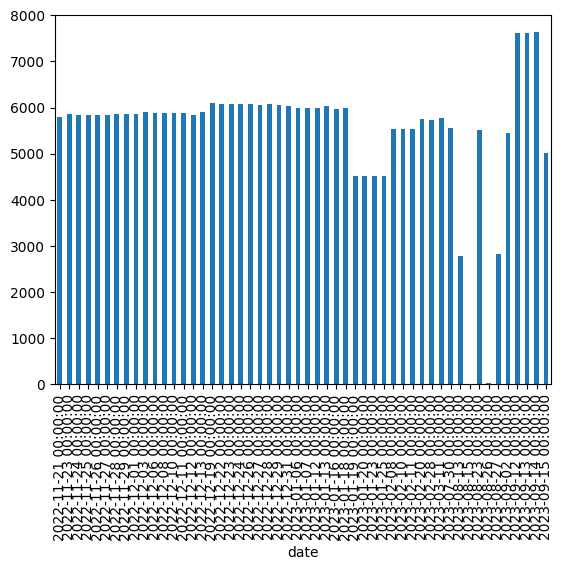

In [20]:
df.groupby("date")["product_id"].agg(pd.Series.nunique).plot(kind="bar")

In [38]:
df14 = df[df.date=='2023-09-14']

In [42]:
df15 = df[df.date=='2023-09-15']

In [51]:
df14[~df14["product_id"].isin(df15["product_id"])]

,product_id,product,brand,categories,units,price,unit_price,discount,date,ts_load
258598,295181,Filetes de gallineta,Mar,"[Congelados, Pescado y marisco]",€/KILO),3.99,9.98,NaN,2023-09-14,2023-09-14 07:48:41.346634
258599,295386,Chocolate con leche con relleno cremoso y troc...,Tosta,"[Azúcar. chocolates y caramelos, Chocolates y ...",€/KILO),1.25,14.88,NaN,2023-09-14,2023-09-14 07:48:41.630712
258600,29586,Buey de mar cocido,Mari,"[Congelados, Pescado y marisco]",€/KILO),6.99,15.53,NaN,2023-09-14,2023-09-14 07:48:41.811171
258601,296119,Galletas choco leche,Artiach,"[Galletas. bollos y cereales, Galletas]",€/KILO),2.99,11.73,NaN,2023-09-14,2023-09-14 07:48:42.031784
258602,296364,Aceitunas rellenas de boquerón marinas,La,"[Patatas fritas. encurtidos y frutos secos, Ac...",€/KILO),1.85,14.23,NaN,2023-09-14,2023-09-14 07:48:42.329678
...,...,...,...,...,...,...,...,...,...,...
289661,82867,Chocolate con leche y avellanas,Temptation,"[Azúcar. chocolates y caramelos, Chocolates y ...",€/KILO),1.15,7.67,NaN,2023-09-14,2023-09-14 07:55:03.648706
289662,84349,Whisky bourbon,Jim,"[Cervezas. vinos y bebidas con alcohol, Ron y ...",€/LITRO),13.99,19.99,NaN,2023-09-14,2023-09-14 07:55:03.871185
289663,86108,Magdalenas rellenas con crema de cacao,El,"[Galletas. bollos y cereales, Bollería]",€/KILO),1.69,5.03,NaN,2023-09-14,2023-09-14 07:55:04.118279
289664,8834,Barquillo relleno de praliné y chocolate,Knoppers,"[Azúcar. chocolates y caramelos, Chocolates y ...",€/KILO),2.09,16.72,NaN,2023-09-14,2023-09-14 07:55:04.380169
